## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed
rseed = 42

## Load and explore data

In [4]:
# Import the dataset
df = pd.read_csv('Country-data.csv')

In [5]:
# Check the shape
print("Shape of the dataset:", df.shape)

Shape of the dataset: (167, 10)


In [6]:
# Check datatypes & counts
print("\nDatatypes and counts:")
print(df.dtypes)
print("\nCounts:")
print(df.count())


Datatypes and counts:
country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

Counts:
country       167
child_mort    167
exports       167
health        167
imports       167
income        167
inflation     167
life_expec    167
total_fer     167
gdpp          167
dtype: int64


In [7]:
# Get descriptive statistics
descriptive_stats = df.describe()
print(descriptive_stats)

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000

In [8]:
# Identify any missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


## Preprocessing and Feature Selection

In [24]:
# Drop any non-numeric features (columns)
df_numeric = df.select_dtypes(include=['number'])

print("\nShape after dropping non-numeric columns:", df_numeric.shape)


Shape after dropping non-numeric columns: (167, 9)


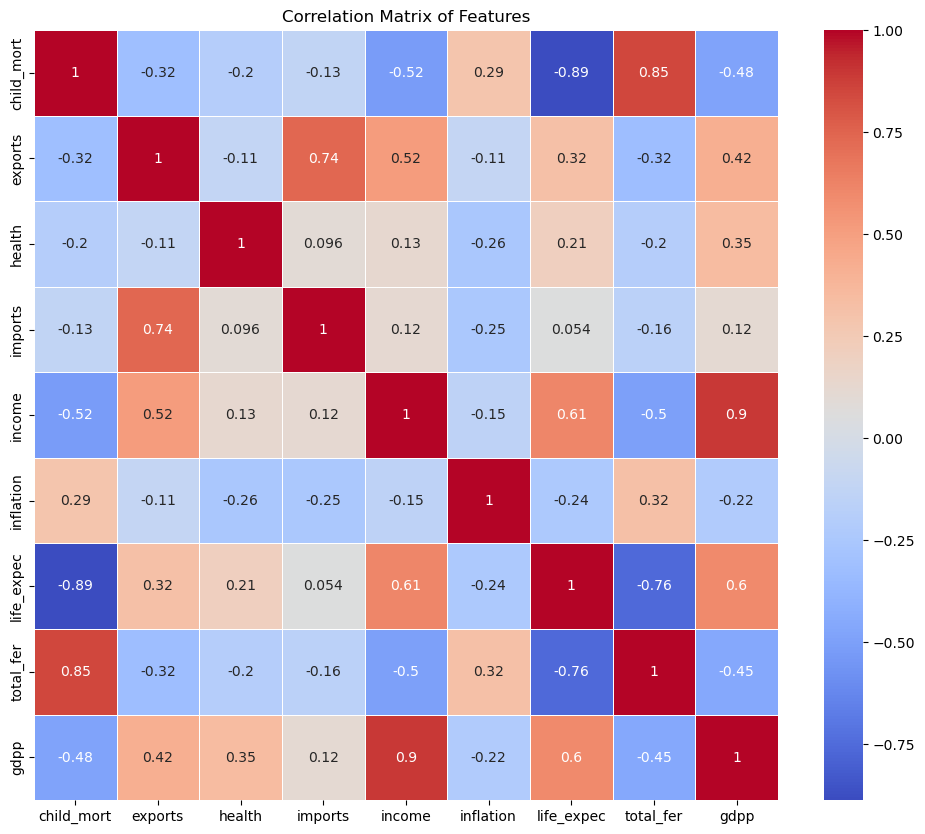

In [25]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


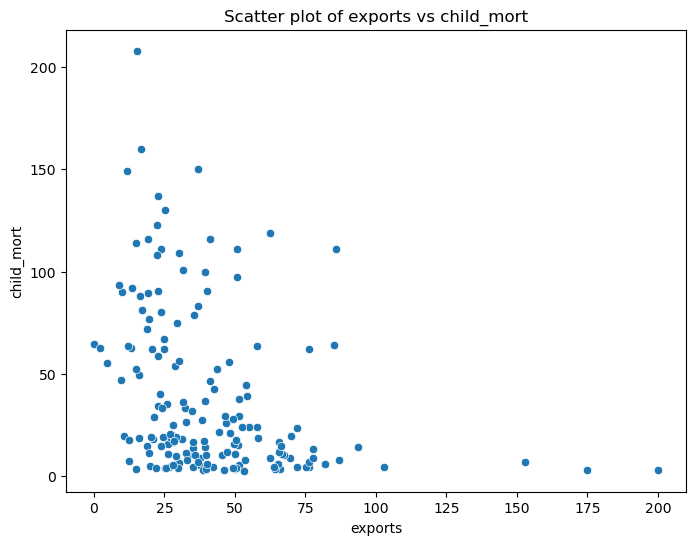

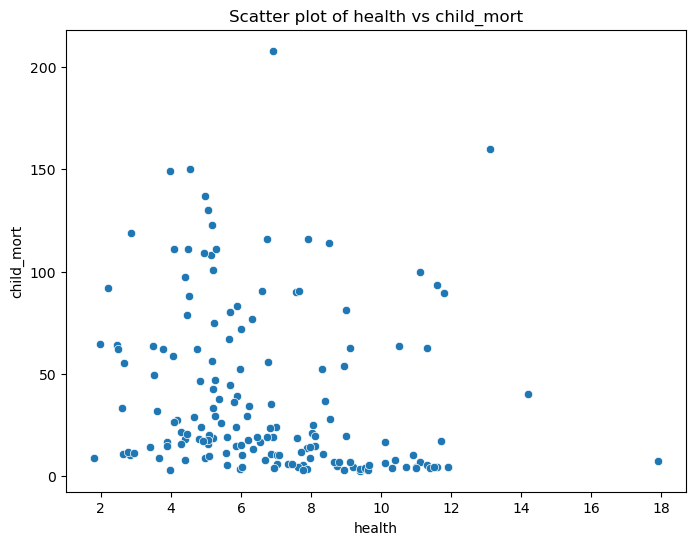

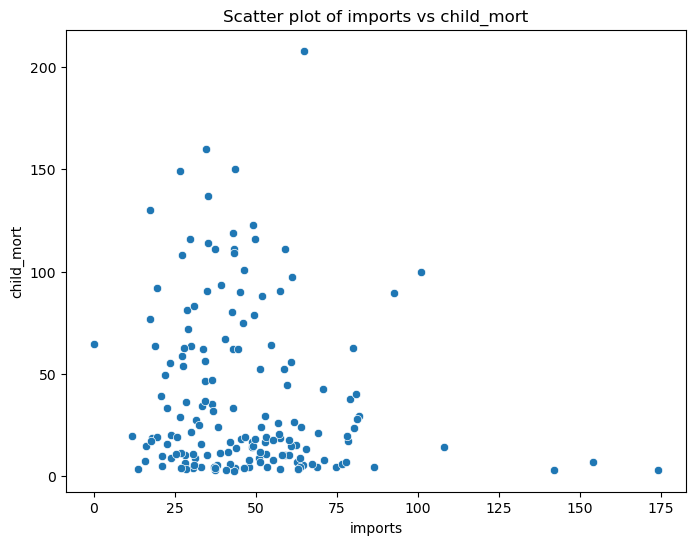

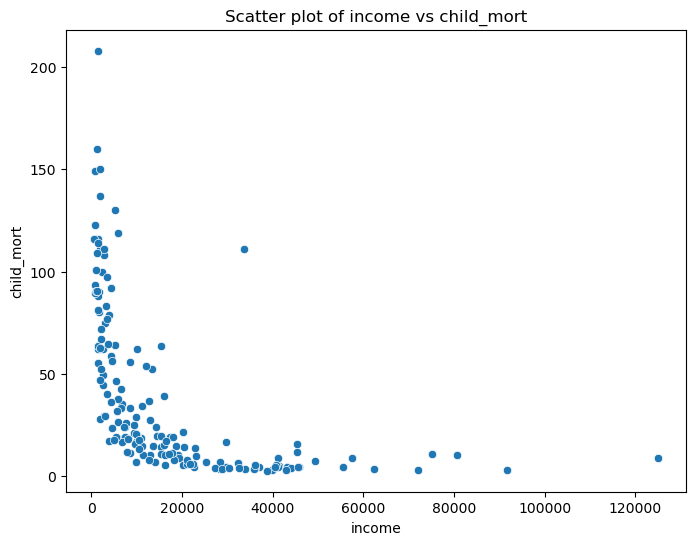

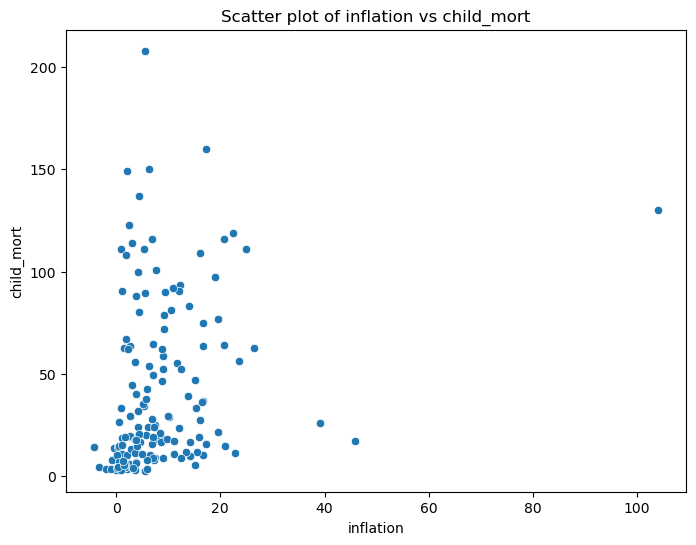

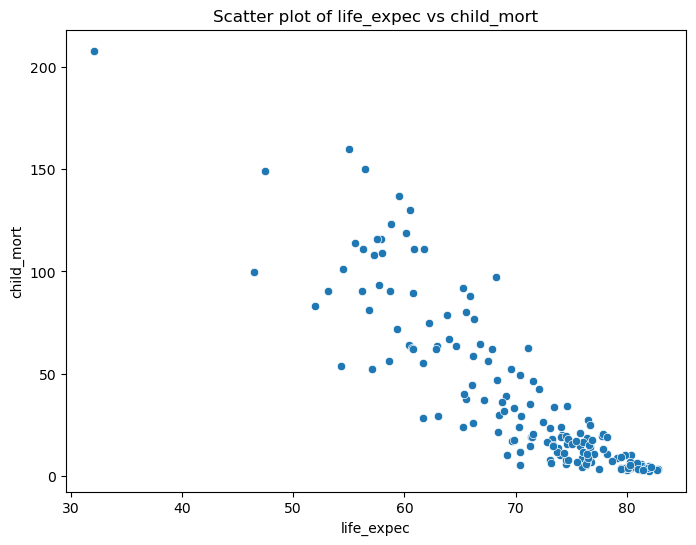

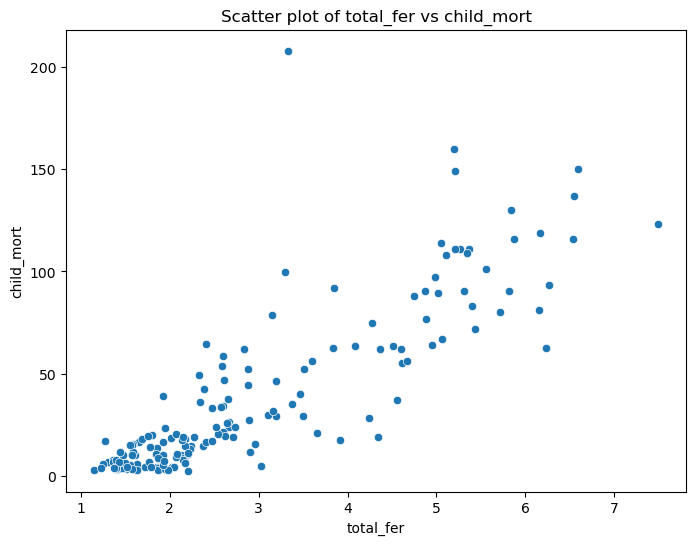

In [11]:
# Explore the continuous independent features against child_mort using scatter plots.
continuous_features = df.select_dtypes(include=['float64', 'int64']).columns.drop(['child_mort', 'gdpp'])

for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=feature, y='child_mort')
    plt.title(f'Scatter plot of {feature} vs child_mort')
    plt.xlabel(feature)
    plt.ylabel('child_mort')
    plt.show()

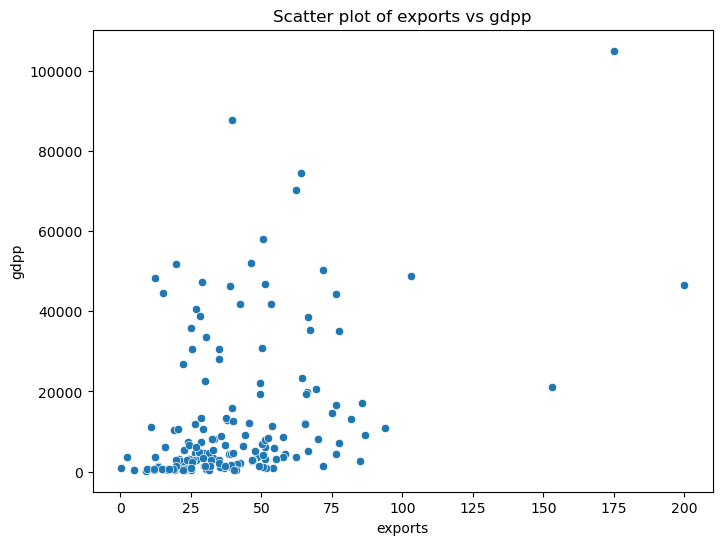

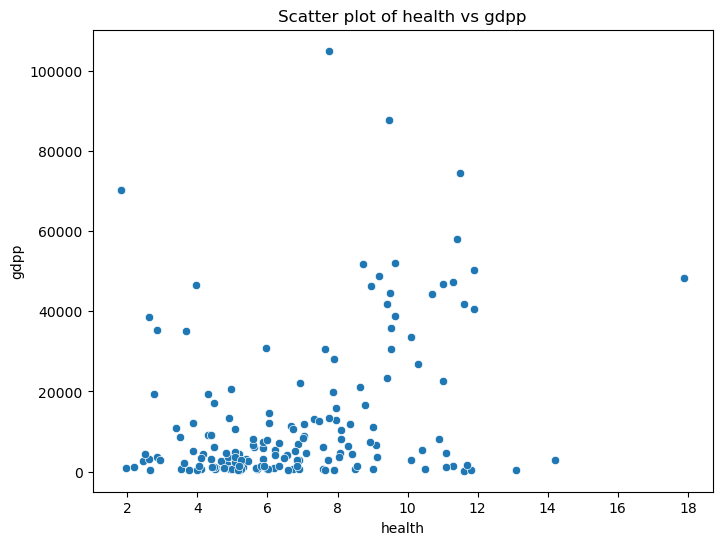

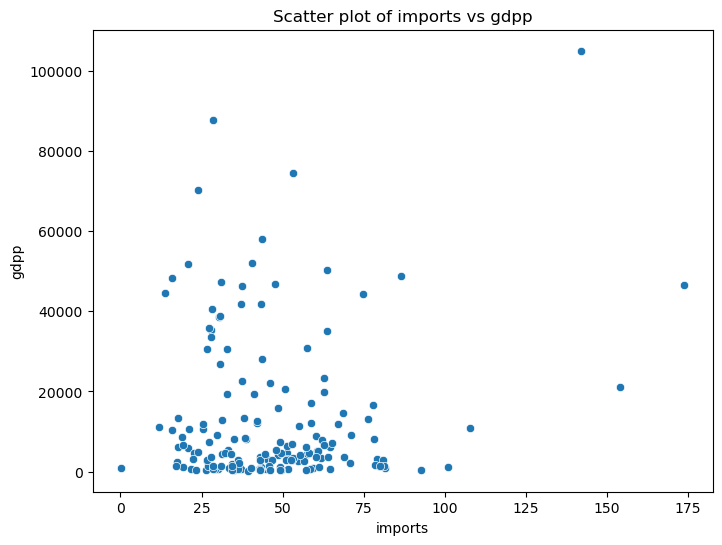

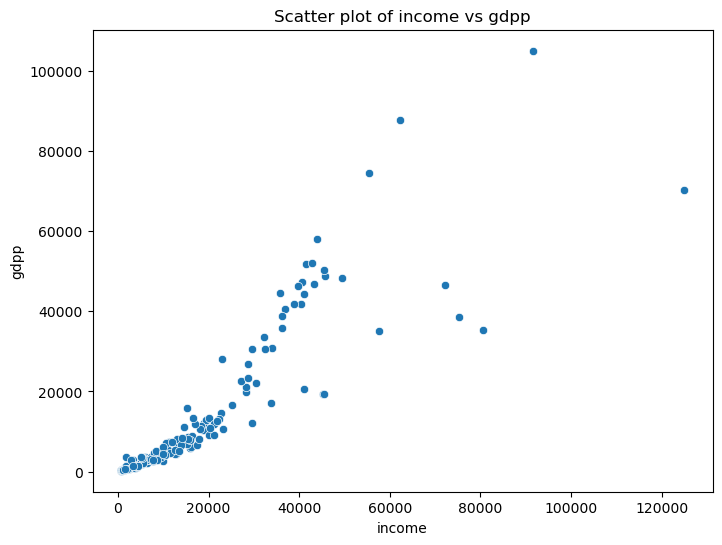

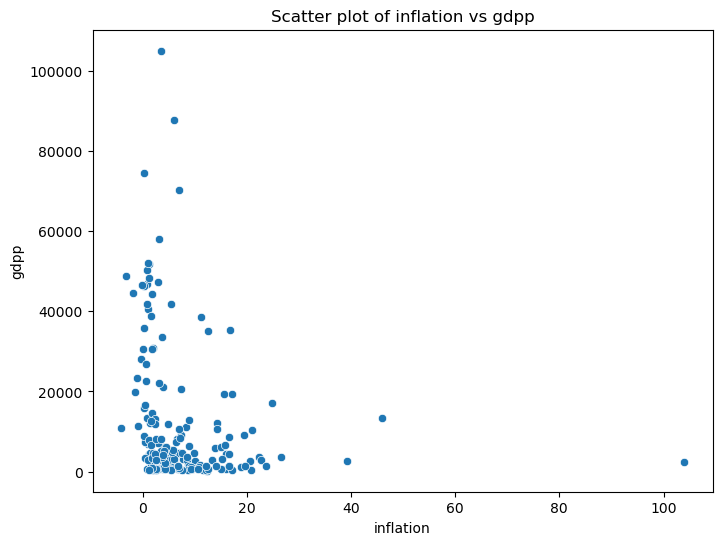

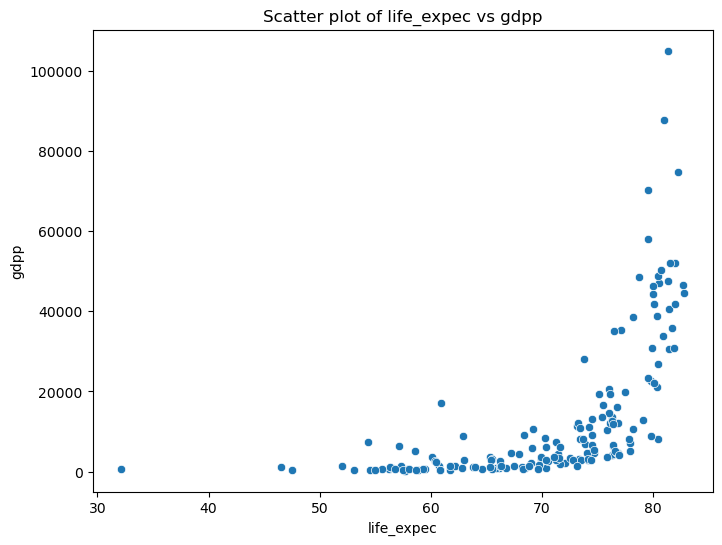

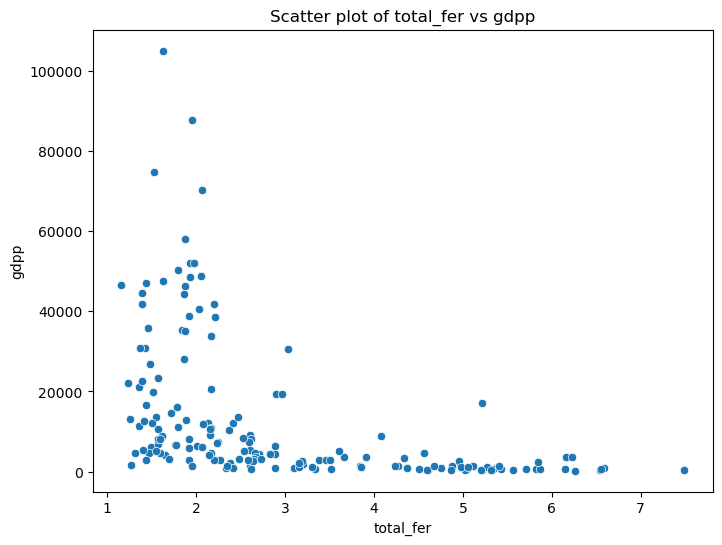

In [12]:
# Explore the continuous independent features against gdpp using scatter plots.
for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=feature, y='gdpp')
    plt.title(f'Scatter plot of {feature} vs gdpp')
    plt.xlabel(feature)
    plt.ylabel('gdpp')
    plt.show()

<Figure size 1200x800 with 0 Axes>

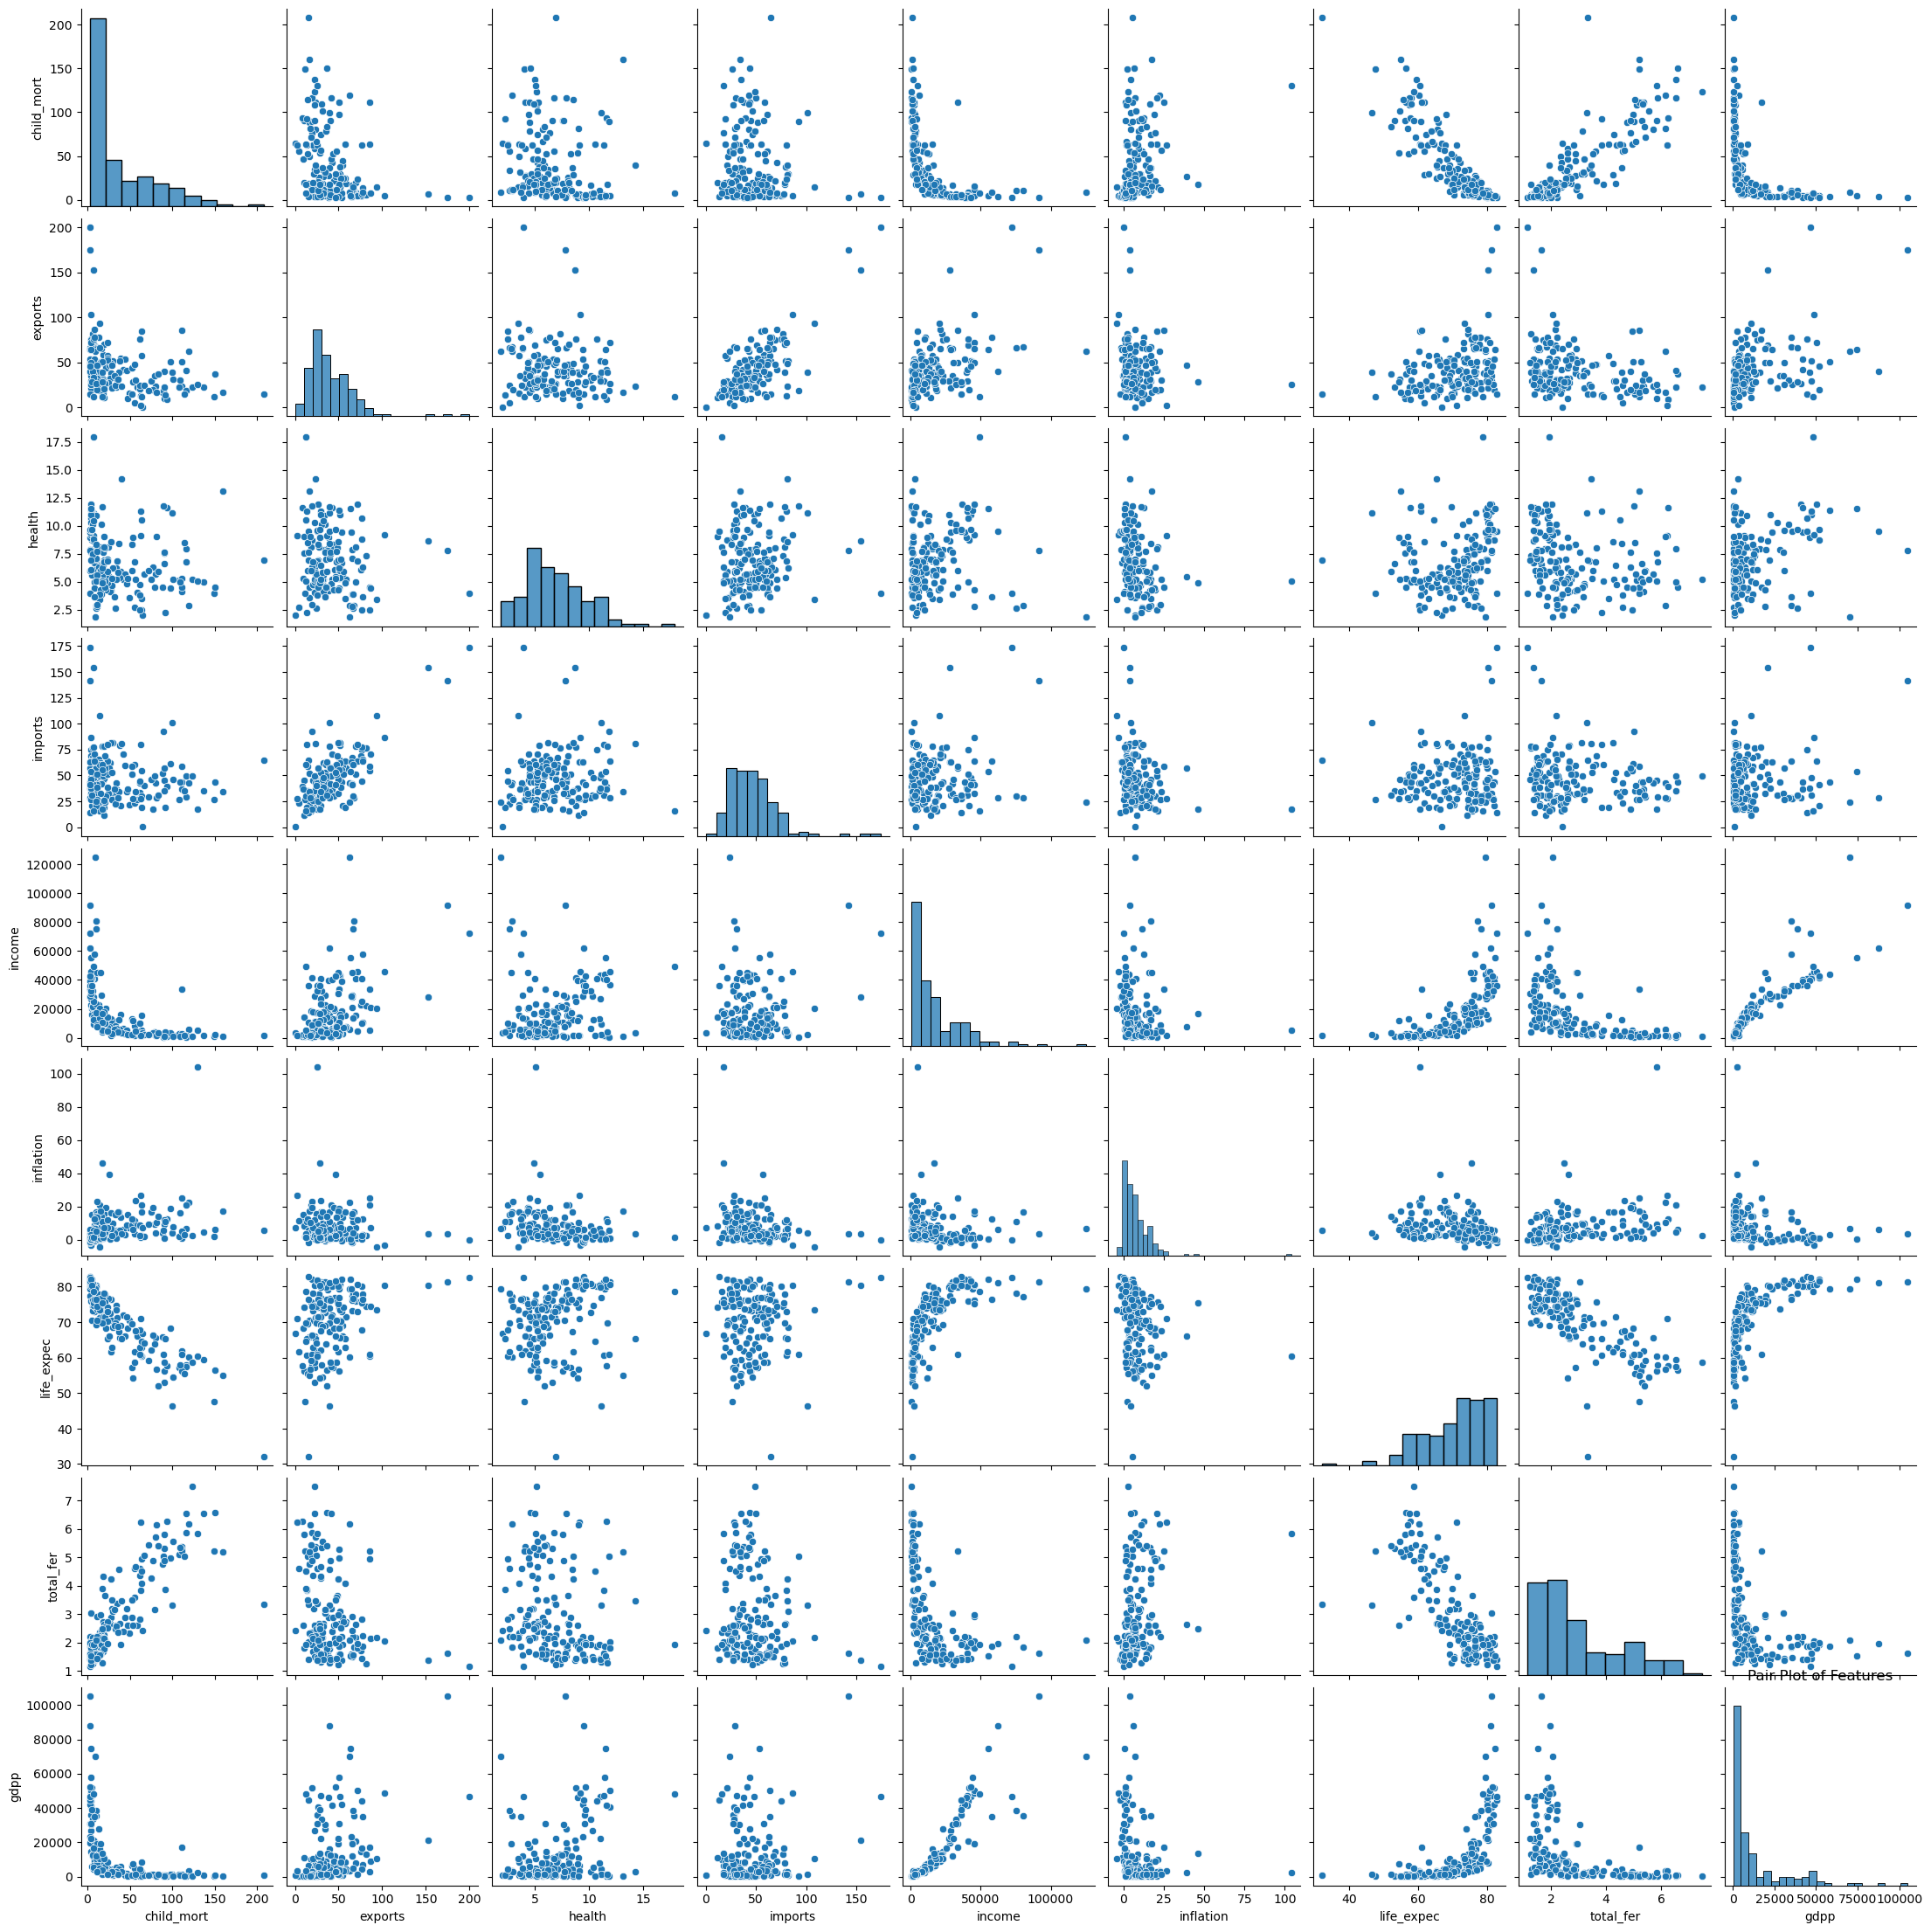

In [13]:
# Create a pair plot
# Hint: Explore seaborn pairplot
plt.figure(figsize=(12, 8))
sns.pairplot(df)
plt.title('Pair Plot of Features')
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [14]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"


# df_scaled.head()

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

print("\nScaled dataset:")
print(df_scaled.head())


Scaled dataset:
   child_mort   exports    health   imports    income  inflation  life_expec  \
0    0.426485  0.049482  0.358608  0.257765  0.008047   0.126144    0.475345   
1    0.068160  0.139531  0.294593  0.279037  0.074933   0.080399    0.871795   
2    0.120253  0.191559  0.146675  0.180149  0.098809   0.187691    0.875740   
3    0.566699  0.311125  0.064636  0.246266  0.042535   0.245911    0.552268   
4    0.037488  0.227079  0.262275  0.338255  0.148652   0.052213    0.881657   

   total_fer      gdpp  
0   0.736593  0.003073  
1   0.078864  0.036833  
2   0.274448  0.040365  
3   0.790221  0.031488  
4   0.154574  0.114242  


## K-Means Clustering

### Selecting K

In [15]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset

C:\Users\Intel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Intel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Intel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Intel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

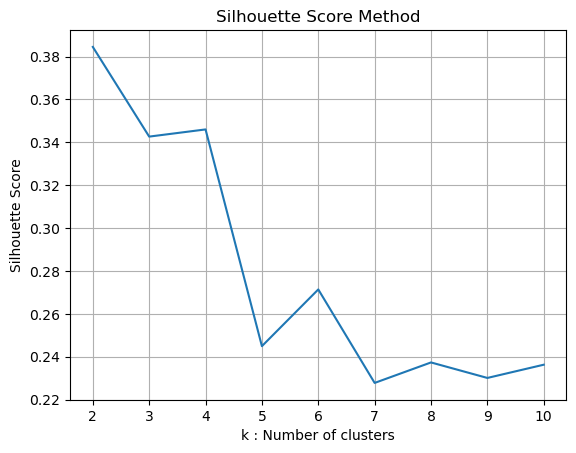

In [16]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

## Fitting a K-Means Model with the selected K value

In [27]:
# Remember to set the random_state to rseed
rseed = 42

K = 3

In [29]:
# Count the number of records in each cluster
df = df.select_dtypes(include=[np.number])

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)

clusters = kmeans.predict(scaled_df)

df['Cluster'] = clusters

cluster_counts = df['Cluster'].value_counts()
print("Number of records in each cluster:\n", cluster_counts)

C:\Users\Intel\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Number of records in each cluster:
 1    47
6    38
4    23
3    17
8    17
7     9
2     7
0     5
5     3
9     1
Name: Cluster, dtype: int64


In [30]:
# Check model performance with the silhouette coefficient
silhouette_avg = silhouette_score(scaled_df, clusters)
print("Silhouette Coefficient:", silhouette_avg)


Silhouette Coefficient: 0.23629352095186848


## Predictions

In [31]:
# Add the predicted cluster label column to the original dataframe
df_scaled['Cluster'] = kmeans.labels_

## Visualisation of clusters

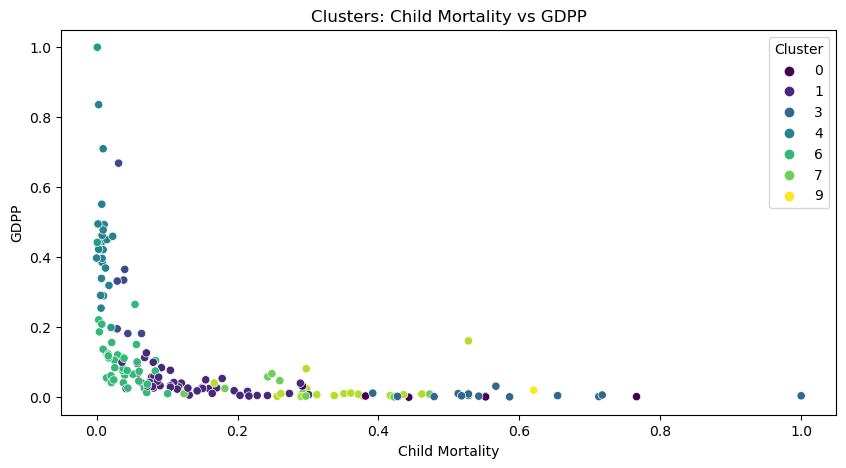

In [36]:
# Visualisation of clusters: child mortality vs gdpp
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_scaled, x='child_mort', y='gdpp', hue='Cluster', palette='viridis')
plt.title('Clusters: Child Mortality vs GDPP')
plt.xlabel('Child Mortality')
plt.ylabel('GDPP')
plt.legend(title='Cluster')
plt.show()

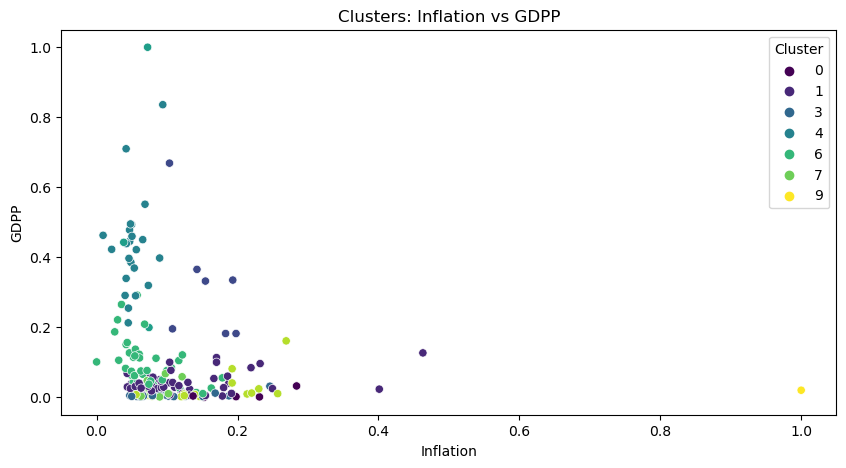

In [38]:
# Visualisation of clusters: inflation vs gdpp
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_scaled, x='inflation', y='gdpp', hue='Cluster', palette='viridis')
plt.title('Clusters: Inflation vs GDPP')
plt.xlabel('Inflation')
plt.ylabel('GDPP')
plt.legend(title='Cluster')
plt.show()

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

In [40]:
labels = {0: 'Least Developed', 1: 'Developing', 2: 'Developed'}

df['Development Status'] = df['Cluster'].map(labels)

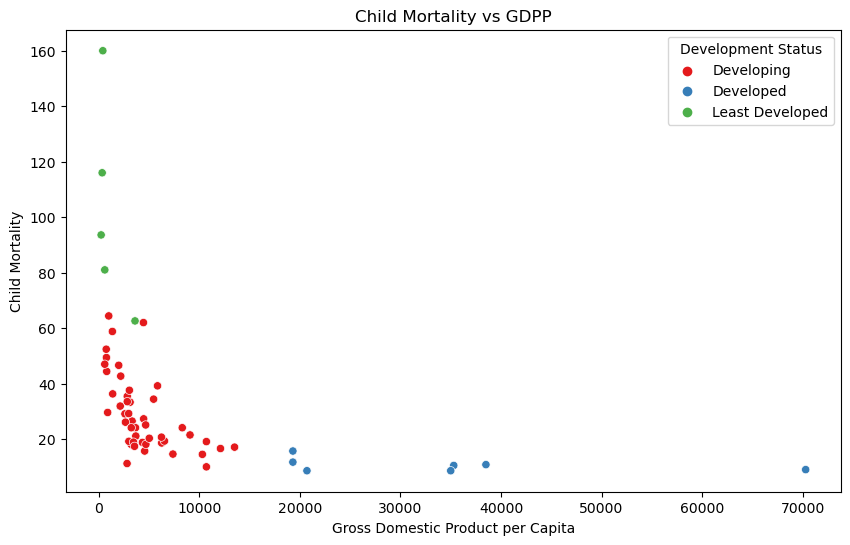

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='gdpp', y='child_mort', hue='Development Status', palette='Set1')
plt.title('Child Mortality vs GDPP')
plt.xlabel('Gross Domestic Product per Capita')
plt.ylabel('Child Mortality')
plt.legend(title='Development Status')
plt.show()

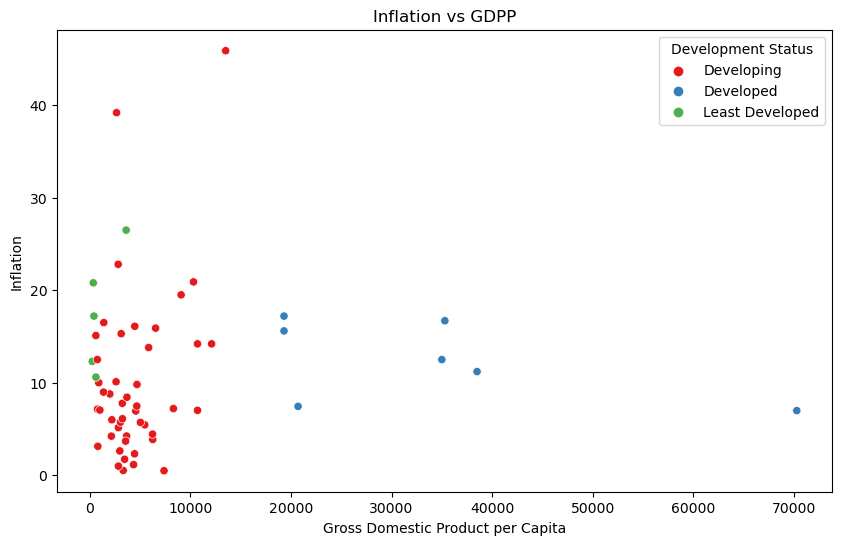

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='gdpp', y='inflation', hue='Development Status', palette='Set1')
plt.title('Inflation vs GDPP')
plt.xlabel('Gross Domestic Product per Capita')
plt.ylabel('Inflation')
plt.legend(title='Development Status')
plt.show()

In [ ]:
#Least Developed: These countries typically have high child mortality rates, low GDPP, and potentially high inflation. These indicators reflect significant economic and social challenges.
#Developing: These countries show moderate levels of child mortality, GDPP, and inflation. They are in a transitional phase with improving economic and social indicators.
#Developed: These countries have low child mortality rates, high GDPP, and low inflation. They generally have stable economies and better living conditions.